# Earthuqake Detection Workflow

## Outline

Here we show an example of the current modules in QuakeFlow

1. Download data using Obpsy:

    [FDSN web service client for ObsPy](https://docs.obspy.org/packages/obspy.clients.fdsn.html#module-obspy.clients.fdsn)
    
    [Mass Downloader for FDSN Compliant Web Services](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html#module-obspy.clients.fdsn.mass_downloader)

2. PhaseNet for picking P/S phases

    Find more details in [PhaseNet github page](https://wayneweiqiang.github.io/PhaseNet/)

3. GaMMA for associating picking and estimate approximate location and magnitude

    Find more details in [GaMMA github page](https://wayneweiqiang.github.io/GMMA/)

4. Earthquake location, magnitude estimation, etc. (to be continued)


## 1. Install [miniconda](https://docs.conda.io/en/latest/miniconda.html)

In [1]:
%%capture
!git clone https://github.com/wayneweiqiang/PhaseNet.git
!git clone https://github.com/wayneweiqiang/GMMA.git
!conda env update -f=env.yml -n base

# # second option: install to quakeflow environment, but need to select jupyter notebook kernel to quakflow
# !conda env create -f=env.yml -n quakeflow
# !python -m ipykernel install --user --name=quakeflow

In [2]:
import warnings
warnings.filterwarnings("ignore")
import kfp
import kfp.dsl as dsl
import kfp.components as comp
from kfp.components import InputPath, OutputPath

## 2. Set configurations

In [3]:
import os
import matplotlib
# matplotlib.use("agg")
import matplotlib.pyplot as plt

region_name = "Ridgecrest_demo"
# region_name = "SaltonSea"
# region_name = "Ridgecrest"
# region_name = "SanSimeon"
# region_name = "Italy"
# region_name = "PNSN"
# region_name = "Hawaii"
# region_name = "PuertoRico"
# region_name = "SmithValley"
dir_name = region_name
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
root_dir = lambda x: os.path.join(dir_name, x)

run_local = True

In [4]:
def set_config(index_json: OutputPath("json"),
               config_json: OutputPath("json"), 
               datetime_json: OutputPath("json"),
               num_parallel:int = 1) -> list:
    
    import obspy
    import os
    import pickle
    import datetime
    import numpy as np
    import json
    
    pi = 3.1415926
    degree2km = pi*6371/180
    
    region_name = "Ridgecrest_demo"
    center = (-117.504, 35.705)
    horizontal_degree = 1.0
    vertical_degree = 1.0
    starttime = obspy.UTCDateTime("2019-07-04T17")
    endtime = obspy.UTCDateTime("2019-07-04T19")
    client = "SCEDC"
    network_list = ["CI"]
    channel_list = "HH*,BH*,EH*,HN*"

#     region_name = "Ridgecrest"
#     center = (-117.504, 35.705)
#     horizontal_degree = 1.0
#     vertical_degree = 1.0
#     starttime = obspy.UTCDateTime("2019-07-04T17")
#     endtime = obspy.UTCDateTime("2019-07-05T00")
# #     starttime = obspy.UTCDateTime("2019-07-04T00")
# #     endtime = obspy.UTCDateTime("2019-07-11T00")
#     client = "SCEDC"
#     network_list = ["CI"]
#     channel_list = "HH*,BH*,EH*,HN*"
    
#     region_name = "Hawaii"
#     center = (-155.32, 19.39)
#     horizontal_degree = 2.0
#     vertical_degree = 2.0
#     starttime = obspy.UTCDateTime("2021-04-01T00")
#     endtime = obspy.UTCDateTime("2021-05-01T00") 
#     client = "IRIS"
#     network_list = ["HV", "PT"]
#     channel_list = "HH*,BH*,EH*,HN*"
    
#     region_name = "PuertoRico"
#     center = (-66.5, 18)
#     horizontal_degree = 3.0
#     vertical_degree = 2.0
# #     starttime = obspy.UTCDateTime("2020-01-07T00")
# #     endtime = obspy.UTCDateTime("2020-01-14T00") 
#     starttime = obspy.UTCDateTime("2018-05-01T00")
#     endtime = obspy.UTCDateTime("2021-05-01T00") 
#     client = "IRIS"
#     network_list = ["*"]
#     channel_list = "HH*,BH*,EH*,HN*"

#     region_name = "SaltonSea"
#     center = (-115.53, 32.98)
#     horizontal_degree = 1.0
#     vertical_degree = 1.0
#     starttime = obspy.UTCDateTime("2020-10-01T00")
#     endtime = obspy.UTCDateTime("2020-10-01T02")
#     client = "SCEDC"
#     network_list = ["CI"]
#     channel_list = "HH*,BH*,EH*,HN*"

#     region_name = "2003SanSimeon"
#     center = (-121.101, 35.701)
#     horizontal_degree = 1.0
#     vertical_degree = 1.0
#     starttime = obspy.UTCDateTime("2003-12-22T00")
#     endtime = obspy.UTCDateTime("2003-12-24T00") 
#     client = "NCEDC"
#     network_list = ["*"]
#     channel_list = "HH*,BH*,EH*,HN*"
    
#     region_name = "Italy"
#     center = (13.188, 42.723)
#     horizontal_degree = 1.0
#     vertical_degree = 1.0
#     starttime = obspy.UTCDateTime("2016-08-24T00")
#     endtime = obspy.UTCDateTime("2016-08-26T00")
#     client = "INGV"
#     network_list = ["*"]
#     channel_list = "HH*,BH*,EH*,HN*"

    # region_name = "SmithValley"
    # center = (-119.5, 38.51)
    # horizontal_degree = 1.0
    # vertical_degree = 1.0
    # starttime = obspy.UTCDateTime("2021-07-08T00:00")
    # endtime = obspy.UTCDateTime("2021-07-16T00:00")
    # client = "NCEDC"
    # network_list = ["*"]
    # channel_list = "HH*,BH*,EH*,HN*"

    ####### save config ########
    config = {}
    config["region"] = region_name
    config["center"] = center
    config["xlim_degree"] = [center[0]-horizontal_degree/2, center[0]+horizontal_degree/2]
    config["ylim_degree"] = [center[1]-vertical_degree/2, center[1]+vertical_degree/2]
    config["degree2km"] = degree2km
    config["starttime"] = starttime.datetime.isoformat()
    config["endtime"] = endtime.datetime.isoformat()
    config["networks"] = network_list
    config["channels"] = channel_list
    config["client"] = client

    with open(config_json, 'w') as fp:
        json.dump(config, fp)
        
    one_day = datetime.timedelta(days=1)
    one_hour = datetime.timedelta(hours=1)
    starttimes = []
    tmp_start = starttime
    while tmp_start < endtime:
        starttimes.append(tmp_start.datetime.isoformat())
        tmp_start += one_hour
    
    with open(datetime_json, "w") as fp:
        json.dump({"starttimes": starttimes, "interval": one_hour.total_seconds()}, fp)
        
    if num_parallel == 0:
#         num_parallel = (len(starttimes)-1)//(24*3)+1
#         num_parallel = min(8, len(starttimes))
        num_parallel = 64 - 4
    
    idx = [[] for i in range(num_parallel)]
    for i in range(len(starttimes)):
        idx[i - i//num_parallel*num_parallel].append(i)
        
    with open(index_json, 'w') as fp:
        json.dump(idx, fp)

    return list(range(num_parallel))

In [5]:
if run_local:
    idx = set_config(root_dir("index.json"), root_dir("config.json"), root_dir("datetimes.json"), num_parallel=1)

In [6]:
config_op = comp.func_to_container_op(set_config, 
                                      base_image='zhuwq0/quakeflow-env:latest',
#                                       base_image='python:3.8',
#                                       packages_to_install= [
#                                           "numpy",
#                                           "obspy",
#                                       ]
                                     )

## 3. Download events in the routine catalog

This catalog is not used by QuakeFolow. It is only used for comparing detection results.

In [7]:
def download_events(config_json: InputPath("json"),
                    event_csv: OutputPath(str)):
    
    import pickle, os
    import obspy
    from obspy.clients.fdsn import Client
    from collections import defaultdict
    import pandas as pd
    import json
    import matplotlib
#     matplotlib.use("agg")
    import matplotlib.pyplot as plt
    
    with open(config_json, "r") as fp:
        config = json.load(fp)
    
    ####### IRIS catalog ########
    try:
        events = Client(config["client"]).get_events(starttime=config["starttime"],
                                           endtime=config["endtime"],
                                           minlongitude=config["xlim_degree"][0],
                                           maxlongitude=config["xlim_degree"][1],
                                           minlatitude=config["ylim_degree"][0],
                                           maxlatitude=config["ylim_degree"][1])#,
    #                                        filename='events.xml')
    except:
        events = Client("iris").get_events(starttime=config["starttime"],
                                   endtime=config["endtime"],
                                   minlongitude=config["xlim_degree"][0],
                                   maxlongitude=config["xlim_degree"][1],
                                   minlatitude=config["ylim_degree"][0],
                                   maxlatitude=config["ylim_degree"][1])#,
#                                        filename='events.xml')

#     events = obspy.read_events('events.xml')
    print(f"Number of events: {len(events)}")
#     events.plot('local', outfile="events.png")
#     events.plot('local')

    ####### Save catalog ########
    catalog = defaultdict(list)
    for event in events:
        if len(event.magnitudes) > 0:
            catalog["time"].append(event.origins[0].time.datetime)
            catalog["magnitude"].append(event.magnitudes[0].mag)
            catalog["longitude"].append(event.origins[0].longitude)
            catalog["latitude"].append(event.origins[0].latitude)
            catalog["depth(m)"].append(event.origins[0].depth)
    catalog = pd.DataFrame.from_dict(catalog).sort_values(["time"])
    catalog.to_csv(event_csv,
                   sep="\t", index=False, float_format="%.3f",
                   date_format='%Y-%m-%dT%H:%M:%S.%f',
                   columns=["time", "magnitude", "longitude", "latitude", "depth(m)"])

    ####### Plot catalog ########
    plt.figure()
    plt.plot(catalog["longitude"], catalog["latitude"], '.', markersize=1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis("scaled")
    plt.xlim(config["xlim_degree"])
    plt.ylim(config["ylim_degree"])
#     plt.savefig(os.path.join(data_path, "events_loc.png"))
    plt.show();
    
    plt.figure()
    plt.plot_date(catalog["time"], catalog["magnitude"], '.', markersize=1)
    plt.gcf().autofmt_xdate()
    plt.ylabel("Magnitude")
    plt.title(f"Number of events: {len(events)}")
#     plt.savefig(os.path.join(data_path, "events_mag_time.png"))
    plt.show();

Number of events: 252


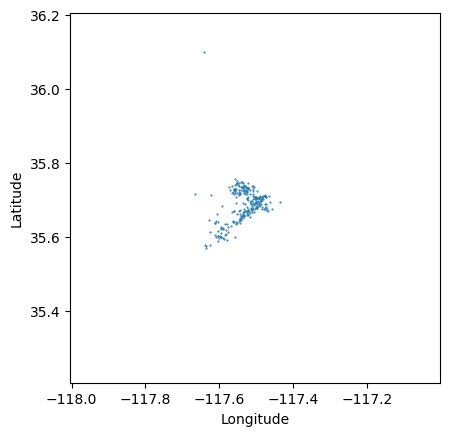

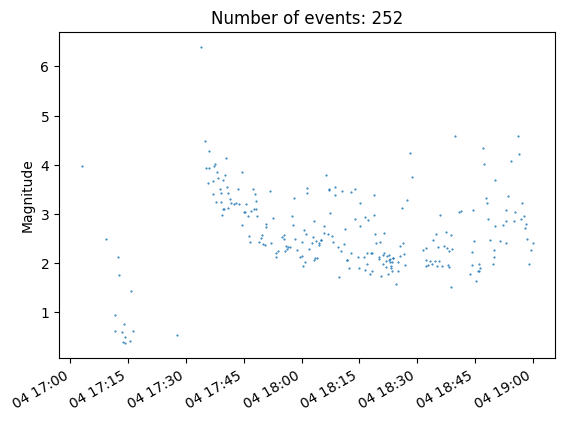

In [8]:
if run_local:
    download_events(root_dir("config.json"), root_dir("events.csv"))

In [9]:
download_events_op = comp.func_to_container_op(download_events, 
                                               base_image='zhuwq0/quakeflow-env:latest',
#                                                base_image='python:3.8',
#                                                packages_to_install= [
#                                                   "obspy",
#                                                   "pandas",
#                                                   "matplotlib",
#                                                ]
                                              )

## 4. Download stations

In [10]:
def download_stations(config_json: InputPath("json"),
                      station_csv: OutputPath(str),
                      station_pkl: OutputPath("pickle")):
    
    import pickle, os
    import obspy
    from obspy.clients.fdsn import Client
    from collections import defaultdict
    import pandas as pd
    import json
    import matplotlib
#     matplotlib.use("agg")
    import matplotlib.pyplot as plt
    
    with open(config_json, "r") as fp:
        config = json.load(fp)

    print("Network:", ",".join(config["networks"]))
    ####### Download stations ########
    stations = Client(config["client"]).get_stations(network = ",".join(config["networks"]),
                                           station = "*",
                                           starttime=config["starttime"],
                                           endtime=config["endtime"],
                                           minlongitude=config["xlim_degree"][0],
                                           maxlongitude=config["xlim_degree"][1],
                                           minlatitude=config["ylim_degree"][0],
                                           maxlatitude=config["ylim_degree"][1],
                                           channel=config["channels"],
                                           level="response")#,
#                                            filename="stations.xml")

#     stations = obspy.read_inventory("stations.xml")
    print("Number of stations: {}".format(sum([len(x) for x in stations])))
    # stations.plot('local', outfile="stations.png")
#     stations.plot('local')
    
    ####### Save stations ########
    station_locs = defaultdict(dict)
    for network in stations:
        for station in network:
            for chn in station:
                sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
                if sid in station_locs:
                    station_locs[sid]["component"] += f",{chn.code[-1]}"
                    station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
                else:
                    component = f"{chn.code[-1]}"
                    response = f"{chn.response.instrument_sensitivity.value:.2f}"
                    dtype = chn.response.instrument_sensitivity.input_units.lower()
                    tmp_dict = {}
                    tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = chn.longitude, chn.latitude, chn.elevation
                    tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                    station_locs[sid] = tmp_dict
                    
    station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
    station_locs.to_csv(station_csv,
                        sep="\t", float_format="%.3f",
                        index_label="station",
                        columns=["longitude", "latitude", "elevation(m)", "unit", "component", "response"])

    with open(station_pkl, "wb") as fp:
        pickle.dump(stations, fp)
        
#     ####### Plot stations ########
    plt.figure()
    plt.plot(station_locs["longitude"], station_locs["latitude"], "^", label="Stations")
    plt.xlabel("X (km)")
    plt.ylabel("Y (km)")
    plt.axis("scaled")
    plt.xlim(config["xlim_degree"])
    plt.ylim(config["ylim_degree"])
    plt.legend()
    plt.title(f"Number of stations: {len(station_locs)}")
#     plt.savefig(os.path.join(data_path, "stations_loc.png"))
    plt.show()

Network: CI
Number of stations: 17


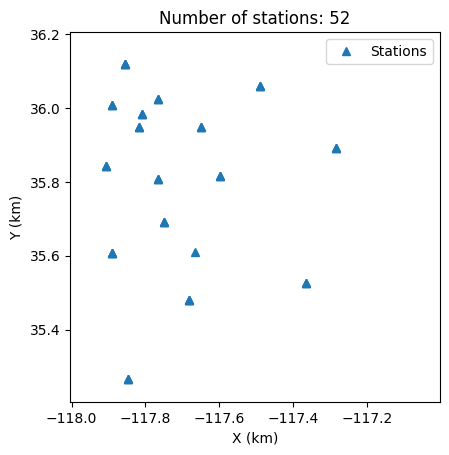

In [11]:
if run_local:
    download_stations(root_dir("config.json"), root_dir("stations.csv"), root_dir("stations.pkl"))

In [12]:
download_stations_op = comp.func_to_container_op(download_stations, 
                                                 base_image='zhuwq0/quakeflow-env:latest',
#                                                  base_image='python:3.8',
#                                                  packages_to_install= [
#                                                      "obspy",
#                                                      "pandas",
#                                                      "matplotlib",
#                                                  ]
                                                )

## 5. Download waveform data

In [13]:
def download_waveform(i: int, 
                      index_json: InputPath("json"),
                      config_json: InputPath("json"),
                      datetime_json: InputPath("json"),
                      station_pkl: InputPath("pickle"),
                      fname_csv: OutputPath(str),
                      data_path:str,
#                       bucket_name:str = "waveforms",
#                       s3_url:str = "localhost:9000", 
#                       secure:bool = True
                     ) -> str:
    
    import pickle, os
    import obspy
    from obspy.clients.fdsn import Client
    import time
    import json
    import random
    import threading
    lock = threading.Lock()
    
#     from minio import Minio
#     minioClient = Minio(s3_url,
#                   access_key='minio',
#                   secret_key='minio123',
#                   secure=secure)
    
#     if not minioClient.bucket_exists(bucket_name):
#         minioClient.make_bucket(bucket_name)

    with open(index_json, "r") as fp:
        index = json.load(fp)
    idx = index[i]
    with open(config_json, "r") as fp:
        config = json.load(fp)
    with open(datetime_json, "r") as fp:
        tmp = json.load(fp)
        starttimes = tmp["starttimes"]
        interval = tmp["interval"]
    with open(station_pkl, "rb") as fp:
        stations = pickle.load(fp)
    
    waveform_dir = os.path.join(data_path, config["region"], "waveforms")
    if not os.path.exists(waveform_dir):
        os.makedirs(waveform_dir)
        
    ####### Download data ########
    client = Client(config["client"])
    fname_list = ["fname"]
    
    def download(i):
#     for i in idx: 
        starttime = obspy.UTCDateTime(starttimes[i]) 
        endtime = starttime + interval
        fname = "{}.mseed".format(starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S"))
        if os.path.exists(os.path.join(waveform_dir, fname)):
            print(f"{fname} exists")
            fname_list.append(fname)
            return
        max_retry = 10
        stream = obspy.Stream()
        print(f"{fname} download starts")
        num_sta = 0
        for network in stations:
            for station in network:
                print(f"********{network.code}.{station.code}********")
                retry = 0
                while retry < max_retry:
                    try:
                        tmp = client.get_waveforms(network.code, station.code, "*", config["channels"], starttime, endtime)
#                         for trace in tmp:
#                             if trace.stats.sampling_rate != 100:
#                                 print(trace)
#                                 trace = trace.interpolate(100, method="linear")
#                             trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
#                             stream.append(trace)
                        stream += tmp
                        num_sta += len(tmp)
                        break
                    except Exception as err:
                        print("Error {}.{}: {}".format(network.code, station.code, err))
                        message = "No data available for request."
                        if str(err)[:len(message)] == message:
                            break
                        retry += 1
                        time.sleep(5)
                        continue
                if retry == max_retry:
                    print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code}")
        
#         stream = stream.merge(fill_value=0)
#         stream = stream.trim(starttime, endtime, pad=True, fill_value=0)
        stream.write(os.path.join(waveform_dir, fname))
        print(f"{fname} download succeeds")
#         minioClient.fput_object(bucket_name, fname, os.path.join(waveform_dir, fname))
        lock.acquire()
        fname_list.append(fname)
        lock.release()
    
    threads = []
    MAX_THREADS = 4
    for ii, i in enumerate(idx):
        t = threading.Thread(target=download, args=(i,))
        t.start()
        time.sleep(1)
        threads.append(t)
        if ii%MAX_THREADS == MAX_THREADS-1:
            for t in threads:
                t.join()
            threads = []
    for t in threads:
        t.join()

    with open(fname_csv, "w") as fp:
        fp.write("\n".join(fname_list))

    return waveform_dir

In [14]:
if run_local:
    waveform_path = download_waveform(0, root_dir("index.json"), root_dir("config.json"), root_dir("datetimes.json"), root_dir("stations.pkl"), root_dir("fname.csv"), data_path=root_dir(""))

2019-07-04T17:00:00.mseed exists
2019-07-04T18:00:00.mseed exists


In [15]:
download_waveform_op = comp.func_to_container_op(download_waveform,
                                                 base_image='zhuwq0/quakeflow-env:latest',
#                                                  base_image='python:3.8',
#                                                  packages_to_install= [
#                                                      "obspy",
# #                                                      "minio"
#                                                  ]
                                                )

In [16]:
def phasenet_op(data_path: str, 
                data_list: str, 
                stations: str):

    return dsl.ContainerOp(name='PhaseNet Picking',
                           image="zhuwq0/phasenet:latest",
                           command=['python'],
                           arguments=[
                             'phasenet/predict.py',
                             '--model', "model/190703-214543",
                             '--data_dir', data_path,
                             '--data_list', dsl.InputArgumentPath(data_list),
                             '--stations', dsl.InputArgumentPath(stations),
#                              '--result_dir', "results",
                             '--format', "mseed_array",
                             '--amplitude'
                             ],
                           file_outputs = {"picks": "/opt/results/picks.json"}
                         )

## 6. Run PhaseNet to pick P/S picks

In [17]:
# %%capture
if run_local:
    command = f"python PhaseNet/phasenet/predict.py --model=PhaseNet/model/190703-214543 --data_dir={root_dir(root_dir('waveforms'))} --data_list={root_dir('fname.csv')} --stations={root_dir('stations.csv')} --result_dir={root_dir('phasenet')} --format=mseed_array --amplitude"
    print(command)
    !{command}

python PhaseNet/phasenet/predict.py --model=PhaseNet/model/190703-214543 --data_dir=Ridgecrest_demo/Ridgecrest_demo/waveforms --data_list=Ridgecrest_demo/fname.csv --stations=Ridgecrest_demo/stations.csv --result_dir=Ridgecrest_demo/phasenet --format=mseed_array --amplitude
           station  longitude  ...  component                                response
0       CI.CCC..BH   -117.365  ...      E,N,Z  627368000.00,627368000.00,627368000.00
1       CI.CCC..HH   -117.365  ...      E,N,Z  627368000.00,627368000.00,627368000.00
2       CI.CCC..HN   -117.365  ...      E,N,Z           213979.00,214322.00,213808.00
3       CI.CLC..BH   -117.598  ...      E,N,Z  627368000.00,627368000.00,627368000.00
4       CI.CLC..HH   -117.598  ...      E,N,Z  627368000.00,627368000.00,627368000.00
5       CI.CLC..HN   -117.598  ...      E,N,Z           213945.00,213808.00,213740.00
6       CI.DTP..BH   -117.846  ...      E,N,Z  627368000.00,627368000.00,627368000.00
7       CI.DTP..HH   -117.846  ...   

## 7. Run GaMMA to associate P/S picks

In [18]:
def gmma(i: int,
         index_json: InputPath("json"),
         config_json: InputPath("json"),
         pick_json: InputPath("json"),
         station_csv: InputPath(str),
         catalog_csv: OutputPath(str),
         picks_csv: OutputPath(str),
         bucket_name:str = "catalogs",
         s3_url:str = "localhost:9000", 
         secure:bool = True) -> str:
    
    import pandas as pd
    from datetime import datetime, timedelta
    from gmma import mixture
    import numpy as np
    from sklearn.cluster import DBSCAN 
    from datetime import datetime, timedelta
    import os
    import json
    import pickle
    from tqdm import tqdm
    from gmma.association import from_seconds, convert_picks_csv, association
    
    catalog_dir = os.path.join("/tmp/", bucket_name)
    if not os.path.exists(catalog_dir):
        os.makedirs(catalog_dir)
    
    ## read config
    with open(index_json, "r") as fp:
        index = json.load(fp)
    idx = index[i]

    with open(config_json, "r") as fp:
        config = json.load(fp)
    
    ## read picks
    picks = pd.read_json(pick_json)
    picks["time_idx"] = picks["timestamp"].apply(lambda x: x.strftime("%Y-%m-%dT%H")) ## process by hours

    ## read stations
    stations = pd.read_csv(station_csv, delimiter="\t")
    stations = stations.rename(columns={"station":"id"})
    stations["x(km)"] = stations["longitude"].apply(lambda x: (x - config["center"][0])*config["degree2km"])
    stations["y(km)"] = stations["latitude"].apply(lambda x: (x - config["center"][1])*config["degree2km"])
    stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

    ## setting GMMA configs
    config["dims"] = ['x(km)', 'y(km)', 'z(km)']
    config["use_dbscan"] = True
    config["use_amplitude"] = True
    config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]
    config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
    config["z(km)"] = (0, 40)
    config["min_picks_per_eq"] = min(len(stations)//2, 10) ##minimum picks per earthquake
    maximum_sample_distance_dgscan = 10 #s
    ## DBSCAN
    config["bfgs_bounds"] = ((config["x(km)"][0]-1, config["x(km)"][1]+1), #x
                            (config["y(km)"][0]-1, config["y(km)"][1]+1), #y
                            (0, config["z(km)"][1]+1), #x
                            (None, None)) #t
    config["dbscan_eps"] = min(np.sqrt((stations["x(km)"].max()-stations["x(km)"].min())**2 +
                                       (stations["y(km)"].max()-stations["y(km)"].min())**2)/(6.0/1.75), maximum_sample_distance_dgscan)
    config["dbscan_min_samples"] = min(len(stations), 3)
    config["oversample_factor"] = min(len(stations)//2, 10)

    for k, v in config.items():
        print(f"{k}: {v}")

    ## if use amplitude
    if config["use_amplitude"]:
        picks = picks[picks["amp"]!=0]

    ## run GMMA association
    pbar = tqdm(sorted(list(set(picks["time_idx"]))))
    event_idx0 = 0 ## current earthquake index
    assignments = []
    if (len(picks) > 0) and (len(picks) < 5000):
        data, locs, phase_type, phase_weight = convert_picks_csv(picks, stations, config)
        catalogs, assignments = association(data, locs, phase_type, phase_weight, len(stations), picks.index.to_numpy(), event_idx0, config, stations, pbar)
        event_idx0 += len(catalogs)
    else:
        catalogs = []
        for i, hour in enumerate(pbar):
            picks_ = picks[picks["time_idx"] == hour]
            if len(picks_) == 0:
                continue
            data, locs, phase_type, phase_weight = convert_picks_csv(picks_, stations, config)
            catalog, assign = association(data, locs, phase_type, phase_weight, len(stations), picks_.index.to_numpy(), event_idx0, config, stations, pbar)
            event_idx0 += len(catalog)
            catalogs.extend(catalog)
            assignments.extend(assign)

    ## create catalog
    catalogs = pd.DataFrame(catalogs, columns=["time(s)"]+config["dims"]+["magnitude", "sigma"])
    catalogs["time"] = catalogs["time(s)"].apply(lambda x: from_seconds(x))
    catalogs["longitude"] = catalogs["x(km)"].apply(lambda x: x/config["degree2km"] + config["center"][0])
    catalogs["latitude"] = catalogs["y(km)"].apply(lambda x: x/config["degree2km"] + config["center"][1])
    catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)
    catalogs["event_idx"] = range(event_idx0)
    if config["use_amplitude"]:
        catalogs["covariance"] = catalogs["sigma"].apply(lambda x: f"{x[0][0]:.3f},{x[1][1]:.3f},{x[0][1]:.3f}")
    else:
        catalogs["covariance"] = catalogs["sigma"].apply(lambda x: f"{x[0][0]:.3f}")
    with open(catalog_csv, 'w') as fp:
        catalogs.to_csv(fp, sep="\t", index=False, 
                        float_format="%.3f",
                        date_format='%Y-%m-%dT%H:%M:%S.%f',
                        columns=["time", "magnitude", "longitude", "latitude", "depth(m)", "covariance", "event_idx"])

    ## add assignment to picks
    assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gmma"])
    picks = picks.join(assignments.set_index("pick_idx")).fillna(-1).astype({'event_idx': int})
    with open(picks_csv, 'w') as fp:
        picks.to_csv(fp, sep="\t", index=False, 
                        date_format='%Y-%m-%dT%H:%M:%S.%f',
                        columns=["id", "timestamp", "type", "prob", "amp", "event_idx", "prob_gmma"])
    
    ## upload to s3 bucket
    try:
        from minio import Minio
        minioClient = Minio(s3_url,
                      access_key='minio',
                      secret_key='minio123',
                      secure=secure)
        if not minioClient.bucket_exists(bucket_name):
            minioClient.make_bucket(bucket_name)
        
        with open(os.path.join(catalog_dir, f"catalog_{idx[0]:04d}.csv"), 'w') as fp:
            catalogs.to_csv(fp, sep="\t", index=False, 
                            float_format="%.3f",
                            date_format='%Y-%m-%dT%H:%M:%S.%f',
                            columns=["time", "magnitude", "longitude", "latitude", "depth(m)", "covariance", "event_idx"])
        minioClient.fput_object(bucket_name, f"{config['region']}/catalog_{idx[0]:04d}.csv", os.path.join(catalog_dir, f"catalog_{idx[0]:04d}.csv"))
    
        with open(os.path.join(catalog_dir, f"picks_{idx[0]:04d}.csv"), 'w') as fp:
            picks.to_csv(fp, sep="\t", index=False, 
                            date_format='%Y-%m-%dT%H:%M:%S.%f',
                            columns=["id", "timestamp", "type", "prob", "amp", "event_idx", "prob_gmma"])
        minioClient.fput_object(bucket_name, f"{config['region']}/picks_{idx[0]:04d}.csv", os.path.join(catalog_dir, f"picks_{idx[0]:04d}.csv"))
        
    except Exception as err:
        # print(f"ERROR: can not access minio service! \n{err}")
        pass
    
    return f"catalog_{idx[0]:04d}.csv"
    

In [19]:
if run_local:
    catalog = gmma(0, root_dir("index.json"), root_dir("config.json"), root_dir("phasenet/picks.json"), root_dir("stations.csv"), root_dir("catalog.csv"), root_dir("picks.csv"), bucket_name="catalogs", s3_url="localhost:9000", secure=False)

region: Ridgecrest_demo
center: [-117.504, 35.705]
xlim_degree: [-118.004, -117.004]
ylim_degree: [35.205, 36.205]
degree2km: 111.19492474777779
starttime: 2019-07-04T17:00:00
endtime: 2019-07-04T19:00:00
networks: ['CI']
channels: HH*,BH*,EH*,HN*
client: SCEDC
dims: ['x(km)', 'y(km)', 'z(km)']
use_dbscan: True
use_amplitude: True
x(km): [-55.59746237  55.59746237]
y(km): [-55.59746237  55.59746237]
z(km): (0, 40)
min_picks_per_eq: 10
bfgs_bounds: ((-56.597462373888895, 56.597462373888895), (-56.597462373888895, 56.597462373888895), (0, 41), (None, None))
dbscan_eps: 10
dbscan_min_samples: 3
oversample_factor: 10
Process 12 picks: 100%|██████████| 2/2 [05:19<00:00, 159.92s/it]


In [20]:
gmma_op = comp.func_to_container_op(gmma, 
                                    base_image='zhuwq0/quakeflow-env:latest',
                                   #  base_image='python:3.8',
                                   #  packages_to_install= [
                                   #       "pandas",
                                   #       "numpy",
                                   #       "scikit-learn",
                                   #       "tqdm",
                                   #       "minio",
                                   #       "gmma",
                                   #  ]
                                   )

## 8. Plot catalogs

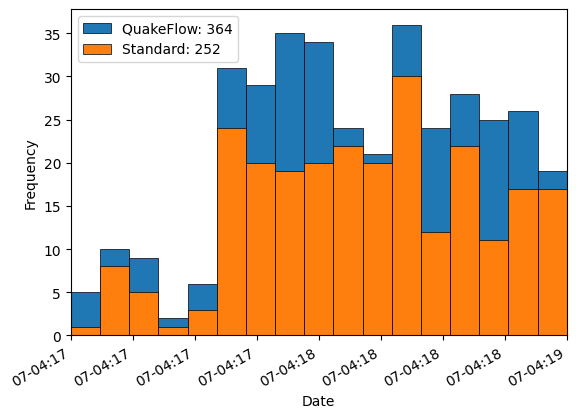

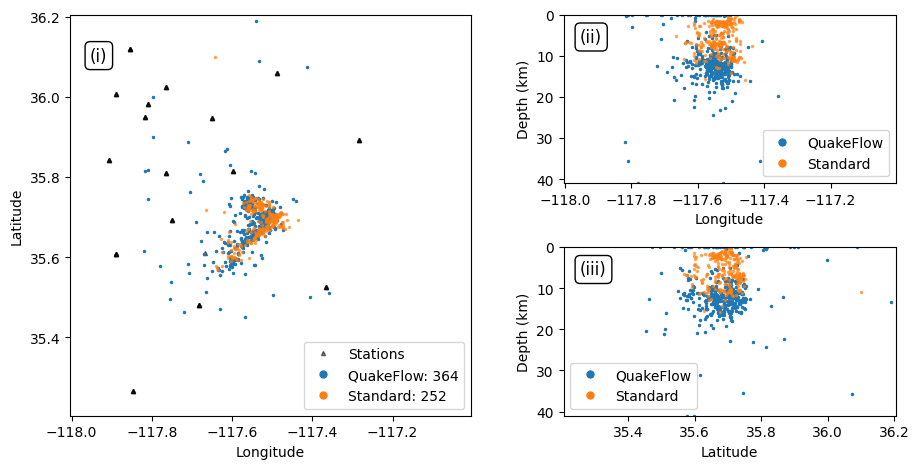

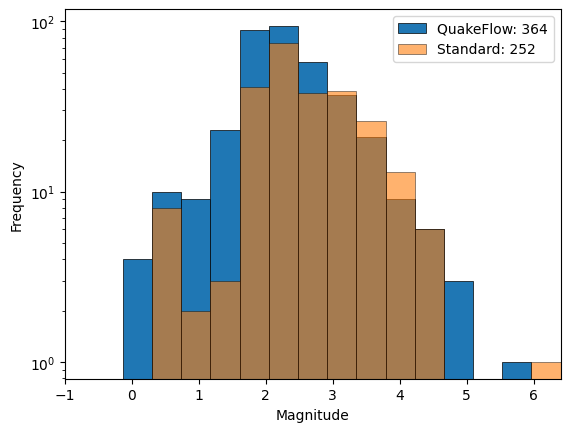

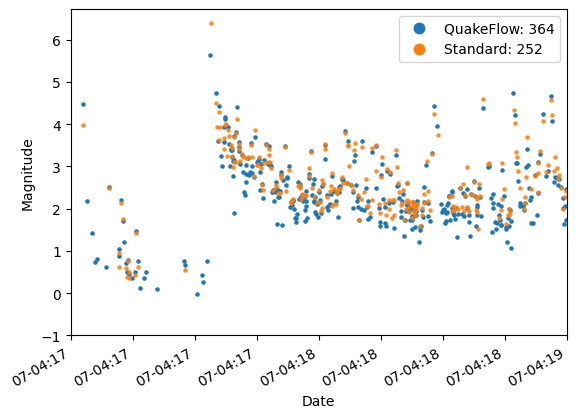

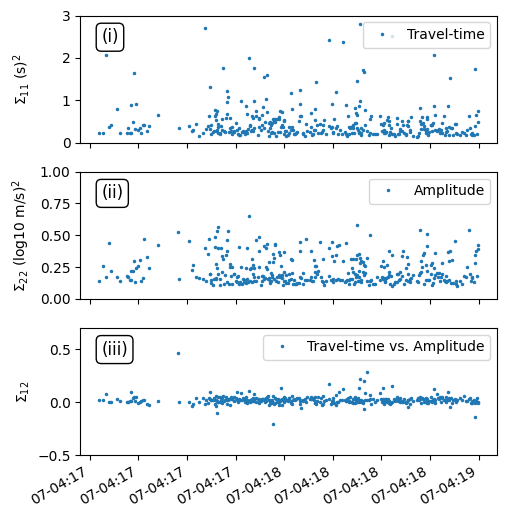

In [29]:
if run_local:
    %run plot_catalog.ipynb

## 9. Parallel processing on cloud

Only run this section for parallel jobs on cloud. Setting cloud environment is needed.

In [22]:
def combine_catalog(config_json: InputPath("json"),
                    catalog_csv: OutputPath(str),
                    picks_csv: OutputPath(str),
                    bucket_name:str = "catalogs",
                    s3_url:str = "minio-service:9000", 
                    secure:bool = True):
     
    import pandas as pd
    from glob import glob
    import os
    import json 
    
    from minio import Minio
    minioClient = Minio(s3_url,
                  access_key='minio',
                  secret_key='minio123',
                  secure=secure)
    
    with open(config_pkl, "r") as fp:
        config = json.load(fp)
    
    objects = minioClient.list_objects(bucket_name, prefix=config["region"], recursive=True)
    
    tmp_path = lambda x: os.path.join("/tmp/", x)
    for obj in objects:
        print(obj._object_name)
        minioClient.fget_object(bucket_name, obj._object_name, tmp_path(obj._object_name.split("/")[-1]))
    
    files_catalog = sorted(glob(tmp_path("catalog_*.csv")))
    files_picks = sorted(glob(tmp_path("picks_*.csv")))

    if len(files_catalog) > 0:
        catalog_list = []
        for f in files_catalog:
            tmp = pd.read_csv(f, sep="\t", dtype=str)
            tmp["file_index"] = f.rstrip(".csv").split("_")[-1]
            catalog_list.append(tmp)        
        combined_catalog = pd.concat(catalog_list).sort_values(by="time")
        combined_catalog.to_csv(tmp_path("combined_catalog.csv"), sep="\t", index=False)
        minioClient.fput_object(bucket_name, f"{config['region']}/combined_catalog.csv", tmp_path("combined_catalog.csv"))
        
        pick_list = []
        for f in files_picks:
            tmp = pd.read_csv(f, sep="\t", dtype=str)
            tmp["file_index"] = f.rstrip(".csv").split("_")[-1]
            pick_list.append(tmp) 
        combined_picks = pd.concat(pick_list).sort_values(by="timestamp")
        combined_picks.to_csv(tmp_path("combined_picks.csv"), sep="\t", index=False)
        minioClient.fput_object(bucket_name, f"{config['region']}/combined_picks.csv", tmp_path("combined_picks.csv"))
        
        with open(catalog_csv, "w") as fout:
            with open(tmp_path("combined_catalog.csv"), "r") as fin:
                for line in fin:
                    fout.write(line)
        with open(picks_csv, "w") as fout:
            with open(tmp_path("combined_picks.csv"), "r") as fin:
                for line in fin:
                    fout.write(line)
    else:
        with open(catalog_csv, "w") as fout:
            pass
        print("No catalog.csv found!")
        with open(picks_csv, "w") as fout:
            pass
        print("No picks.csv found!")


In [23]:
# if run_local
# combine_catalog(root_dir("config.json"), root_dir("combined_catalog.csv"), root_dir("combined_picks.csv"), bucket_name="catalogs", s3_url="localhost:9000", secure=False)

In [24]:
combine_op = comp.func_to_container_op(combine_catalog, 
                                       base_image='zhuwq0/quakeflow-env:latest',
#                                        base_image='python:3.8',
#                                        packages_to_install= [
#                                            "pandas",
#                                            "minio"
#                                        ]
                                      )

In [25]:
# Define the pipeline
@dsl.pipeline(name='QuakeFlow', description='')
def quakeflow_pipeline(data_path:str = "/tmp/", 
                       num_parallel = 0,
                       bucket_catalog:str = "catalogs",
                       s3_url:str="minio-service:9000", 
                       secure:bool=False):
    
    
    config = config_op(num_parallel)

    events = download_events_op(config.outputs["config_pkl"])
    
    stations = download_stations_op(config.outputs["config_pkl"])
    

    with kfp.dsl.ParallelFor(config.outputs["output"]) as i:

        vop_ = dsl.VolumeOp(name=f"Create volume",
                            resource_name=f"data-volume-{str(i)}", 
                            size="50Gi", 
                            modes=dsl.VOLUME_MODE_RWO).set_retry(3)
        
        download_op_ = download_waveform_op(i, 
                                            config.outputs["index_json"], 
                                            config.outputs["config_json"], 
                                            config.outputs["datetime_json"], 
                                            stations.outputs["station_pkl"],
                                            data_path = data_path
                                           ).add_pvolumes({data_path: vop_.volume}).set_cpu_request("800m").set_retry(3).set_display_name('Download Waveforms')
        download_op_.execution_options.caching_strategy.max_cache_staleness = "P30D"

        phasenet_op_ = phasenet_op(download_op_.outputs["Output"], 
                                   download_op_.outputs["fname_csv"], 
                                   stations.outputs["station_csv"]
                                   ).add_pvolumes({data_path: download_op_.pvolume}).set_memory_request("9G").set_display_name('PhaseNet Picking')
        phasenet_op_.execution_options.caching_strategy.max_cache_staleness = "P30D"

        gmma_op_ = gmma_op(i,
                           config.outputs["index_json"],
                           config.outputs["config_json"],
                           phasenet_op_.outputs["picks"],
                           stations.outputs["station_csv"],
                           bucket_name = f"catalogs",
                           s3_url = s3_url,
                           secure = secure
                           ).set_cpu_request("800m").set_display_name('GaMMA Association')
        gmma_op_.execution_options.caching_strategy.max_cache_staleness = "P0D"
        
#         vop_.delete().after(gmma_op_)

    combine_op_ = combine_op(config.outputs["config_pkl"], bucket_name = f"catalogs", s3_url=s3_url, secure=secure).after(gmma_op_)
    combine_op_.execution_options.caching_strategy.max_cache_staleness = "P0D"

In [26]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/weiqiang/.dotbot/cloud/quakeflow_wayne.json"
experiment_name = 'QuakeFlow'
pipeline_func = quakeflow_pipeline
run_name = pipeline_func.__name__ + '_run'

arguments = {"data_path": "/tmp",
             "num_parallel": 0,
             "bucket_catalog": "catalogs",
             "s3_url": "minio-service:9000",
             "secure": False
             }

if not run_local:
    client = kfp.Client(host="3678ee29ad3572f5-dot-us-west1.pipelines.googleusercontent.com")
    kfp.compiler.Compiler().compile(pipeline_func, '{}.zip'.format(experiment_name))
    results = client.create_run_from_pipeline_func(pipeline_func, 
                                                   experiment_name=experiment_name, 
                                                   run_name=run_name, 
                                                   arguments=arguments)